## **CCE5106 - Advanced Neural Networks**
### **Assignment : Atari Games using Reinforcement Learning**
#### Karl Cini - MSc. Data Science course - 136975M

In [1]:
# Importing Libraries
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Libraries for saving and visualizing agent play
import imageio
import cv2
from IPython.display import Image, display, SVG

In [2]:
gym.__version__

'0.29.1'

In [3]:
# Importing torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter # For Tensorboard visualizations

In [4]:
# Installing Gymnasium wrappers

from gymnasium.wrappers import GrayScaleObservation
from gymnasium.wrappers import ResizeObservation
from gymnasium.wrappers import FrameStack # Setting frame stack
from gymnasium.wrappers import AtariPreprocessing

In [5]:
# Setting device for GPU use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
# Setting the environment
# Please note that render_mode = 'human' was causing errors on my jupyter notebook (I am using Ubuntu 22.04)
# and hence I used the rgb_array mode
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

#### **Random Policy**

First, visualize the behaviour of an agent following a random policy over 1000 steps. <br>

For each step: <br>
• Render the environment. <br>
• Choose a random action. <br>
• Perform the action by stepping through the environment, collecting the reward and determining whether the episode has terminated. <br>
• Reset the environment if the episode has terminated. <br>

Evaluate the performance of the random policy agent by plotting the episode reward.

In [48]:
# Starting the environment in reset mode
observation, info = env.reset(seed=554)

episodes = 1
episode_rewards = 0
results = {}

# Setting the frames per second metadata for rendering
env.metadata['render_fps']= 100

imgs_random = []

for _ in range(1000):
    env.render()
    
    action = env.action_space.sample() # sampling a random action from all valid actions
    observation, reward, terminated, truncated, info = env.step(action)
    episode_rewards += reward
    
    if terminated or truncated:
        observation, info = env.reset()
        results[episodes] = episode_rewards
        
        # Reset episodes rewards
        episode_rewards = 0
        
        # Move on to next episode
        episodes += 1
env.close()

In the above code I have assumed that 1000 steps refer to 1000 frame transitions. Due to the randomness of the actions and the game environment it is not possible to determine the exact number of episodes (one episode deemed to be a full 5 lives game). 

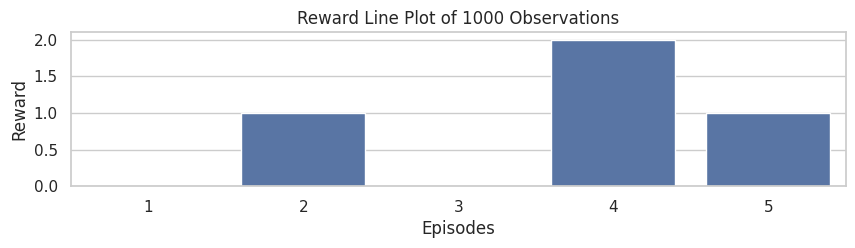

In [49]:
episodes_df = pd.DataFrame.from_dict(results, orient='index')
episodes_df.rename(columns={0:'rewards'}, inplace=True)

sns.set(style="whitegrid")  
plt.figure(figsize=(10, 2)) 

sns.barplot(episodes_df, x=episodes_df.index, y='rewards')

plt.title('Reward Line Plot of 1000 Observations')
plt.xlabel('Episodes')
plt.ylabel('Reward')

plt.show()

In [32]:
observation.shape

(210, 160, 3)

In [33]:
def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  # Hide axis
    plt.show()

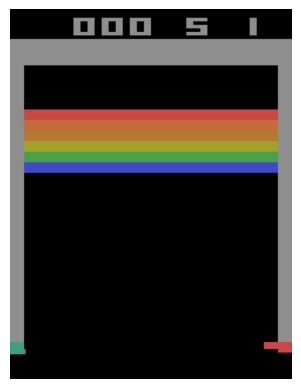

In [34]:
display_image(observation)

#### **Preprocessing the frames**

Each observation is a 210×160×3 array, which is a 210×160 image with three channels (RGB). Since only the locations of the ball and the bat are necessary rather than the colour, convert the observation image frame to grayscale with values normalized to be between 0 and 1. <br>

In order to reduce the state space further to reduce the computational complexity, you can also resize the image to a lower resolution. <br>

One way to do this is to create a Wrapper around the environment, for example you could use TransformObservation, or you could create your own subclass of Wrapper.

##### *Converting to Grayscale*

In [50]:
# Setting the environment to grayscals
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

One option is to use the available GrayScaleObservation class from gymnasium (https://gymnasium.farama.org/api/wrappers/observation_wrappers/). This class requires the current environment as parameters and one has the option to retain a singleton dimension (by using keep_dim = True) returning observations in the shape of AxBX1 or using keep_dim = False and returning a shape of AxB. <br>
*source code : https://gymnasium.farama.org/_modules/gymnasium/wrappers/gray_scale_observation/#GrayScaleObservation*

In [51]:
env = GrayScaleObservation(env, keep_dim=True)

In [52]:
# Starting the environment in reset mode
observation, info = env.reset(seed=554)

episodes = 1
episode_rewards = 0
results = {}

# Setting the frames per second metadata for rendering
env.metadata['render_fps']= 100

for _ in range(100):
    env.render()
    action = env.action_space.sample() # sampling a random action from all valid actions
    observation, reward, terminated, truncated, info = env.step(action)
    episode_rewards += reward
    
    if terminated or truncated:
        observation, info = env.reset()
        results[episodes] = episode_rewards
        
        # Reset episodes rewards
        episode_rewards = 0
        
        # Move on to next episode
        episodes += 1
env.close()

In [53]:
print(observation[0][:10])

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [54]:
observation.shape

(210, 160, 1)

As one can note above, using keep_dim=True returns an observation of the shape 210x160x1. 

##### *Resizing the image*

Gymnasium also has a dedicated class to assist with resizing the image. This can be found here: <br>
https://gymnasium.farama.org/_modules/gymnasium/wrappers/resize_observation/#ResizeObservation

In [55]:
# First checking size of the current environment observation image
env.observation_space.shape

(210, 160, 1)

In [56]:
# Resizing to 105x80
env = ResizeObservation(env, (105,80))

In [57]:
# Checking the new environment observation image size
env.observation_space.shape

(105, 80, 1)

#### **Network architecture(s)**

Using PyTorch, develop sequential model architectures making use of convolutional layers which map the preprocessed observation inputs into a final dense layer of output actions.

The network should be trained on the last 𝑁 frames of the game sequence, rather than on individual frames. That is, instead of having an input which is one frame, the input should be 𝑁 frames. You can start with a value of 𝑁 = 4, and change it later if you think it is appropriate.

In [6]:
# Importing necessary libraries
from collections import namedtuple
from tqdm import tqdm
import os
import random
import math
import time

#### *Setting an architecture*

Inspiration for the below code was taken from various sources over the internet:  <br>

- The Pytorch Tutorial on Reinforcement Learning (DQN) which can be found at *https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html* <br>
- The article 'Reinforcement Learning for Atari Breakout in Python' by Antony Garcia Gonzalez (17/4/2023) : *https://panamahitek.com/en/reinforcement-learning-for-atari-breakout-in-python/* <br>
- The github repository - KJ-Waller/DQN-Pytorch-Breakout : *https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/transforms.py* <br>
- The github repository - ShreeshaN/ReinforcementLearningTutorials : *https://github.com/ShreeshaN/ReinforcementLearningTutorials/tree/master/DQN*
- The paper by Mnih, V. et. al,(2015). *Human-level control through deep reinforcement learning* [1] <br>

Most tutorials present the use of experience replay memory. When querying generative AI on the subject and through further reading it was determined that replay memory is essential for stabilizing and accelerating the training of DQN agents by breaking correlation between experiences, allowing for more efficient use of data, and enabling off-policy learning.

In [7]:
# Create a named tuple to more semantically transform transitions and batches of transitions
Transition = namedtuple('transition', ('state', 'action', 'reward', 'state_', 'terminated'))  

# Memory which allows for storing and sampling batches of transtions
class ReplayBuffer(object):
    def __init__(self, size=6e5): # was 1e6 but reduced to reduce memory capacity
        self.buffer = []
        self.max_size = size
        self.pointer = 0

    # Adds a single transitions to the memory buffer
    def add_transition(self, *args):
        if len(self.buffer) < self.max_size:
            self.buffer.append(None)
        
        self.buffer[self.pointer] = Transition(*args)
        self.pointer = int((self.pointer + 1) % self.max_size)

    # Samples a batch of transitions
    def sample_batch(self, batch_size=32):
        batch = random.sample(self.buffer, batch_size)

        # Converts batch of transitions to transitions of batches
        batch = Transition(*zip(*batch))

        return batch

    def __len__(self):
        return len(self.buffer)

In preparing the network architecture I explored various possibilities. Most of the architectures adopted in the above tutorials make use of the architecture used in various papers. These include: <br>
- DQN learning
- Dueling Network Architectures
- Asynchronous Methids for deep reinforcement learning

and others. Given the restricted resources and to avoid complicating the network architecture (with the risk of slowing the training process) it was decided to follow a basic DQN architecture. <br>

Of notable interest was the suggestion found in some tutorials to use a custom initialisation of weights for the network, rather than having Pytorch initialise it with random weights. This initialisation was implemented accordingly as described in the function setup below. <br>

While various implementations had a custom function for calculating the input dimension to the dense layers (as implemented below), I have also calculated the dimension in the below workings:

*Working for size of first connected layer*

Output Height = (Input Height - Kernel Height + 2 * Padding) / Stride + 1 <br>
Output Width = (Input Width - Kernel Width + 2 * Padding) / Stride + 1 <br>

Input size : 84x84 <br>
Size after 1st convolution layer : ((84 - 8 + (2 * 0)) / 4) + 1 = 20 x 20 <br>
Size after 2nd convolution layer : ((20 - 4 + (2 * 0)) / 2) + 1 = 9 x 9 <br>
Size after 3rd convolution layer : ((9 - 3 + (2 * 0)) / 1) + 1 = 7 x 7 <br>

Hence the input dimension to the dense layers will be 64 x 7 x 7 = 3,136

In [8]:
# adapted from https://github.com/KJ-Waller/DQN-PyTorch-Breakout/blob/master/Breakout/DQN_model.py

# This class defines the DQN network structure
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, filename):
        super(DQN, self).__init__()
        self.input_dim = input_dim
        channels, _ , _= input_dim

        # 3 conv layers, all with relu activations, first one with maxpool
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # Calculate output dimensions for linear layer
        conv_output_size = self.conv_output_dim()
        lin1_output_size = 512

        # Two fully connected layers with one relu activation
        self.l2 = nn.Sequential(
            nn.Linear(conv_output_size, lin1_output_size),
            nn.ReLU(),
            nn.Linear(lin1_output_size, output_dim)
        )

        # Save filename for saving model
        self.filename = filename

    # Calulates output dimension of conv layers
    def conv_output_dim(self):

        x = torch.zeros(1, *self.input_dim)
        x = self.l1(x)
        return int(np.prod(x.shape))

    # Performs forward pass through the network, returns action values
    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.size(0), -1)
        actions = self.l2(x)

        return actions

    # Save a model
    def save_model(self):
        torch.save(self.state_dict(), './models/' + self.filename + '.pt')

    # Loads a model
    def load_model(self):
        self.load_state_dict(torch.load('./models/' + self.filename + '.pt'))

    
    def init_weights(self, m):
        '''
        Inspired by https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756
        and implemented using genAI
        '''

        generator = torch.Generator(device='cuda')
        generator.manual_seed(2024)
        
        # Function to initialize the weights of the neural network at the start of training
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5), generator = generator, nonlinearity='relu')  
            
        elif isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5), generator = generator, nonlinearity='relu')  # Kaiming uniform initialization with scale equal to sqrt(5)
    

In [9]:
# Initializing SummaryWriter() from Tensorboard
writer = SummaryWriter()

### *Creating the Agent*

In [10]:
# This class trains and plays on the actual game

class DQAgent(object):
    # Takes hyperparameters, as well as openai gym environment name
    # Keeps the environment in the class. All learning/playing functions are built in
    def __init__(self, env, state_space, action_space, 
                model_name='breakout_model', gamma=0.99, eps_strt=0.1, 
                eps_end=0.001, eps_dec=5e-6, batch_size=32, lr=0.001, tau=0.005):

        # Set global variables
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.batch_size = batch_size
        self.GAMMA = gamma
        self.LR = lr
        self.eps = eps_strt
        self.eps_dec = eps_dec
        self.eps_end = eps_end
        self.tau = tau

        # Use GPU if available
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # Initialise Replay Memory
        self.memory = ReplayBuffer()

        
        self.learn_counter = 0

        # Initialise policy and target networks, set target network to eval mode
        self.policy_net = DQN(self.state_space, self.action_space, filename=model_name).to(self.device)
        self.target_net = DQN(self.state_space, self.action_space, filename=model_name+'target').to(self.device)
        self.target_net.eval()

        # If pretrained model of the modelname already exists, load it
        try:
            self.policy_net.load_model()
            print('loaded pretrained model')
        except:
            self.policy_net.apply(self.policy_net.init_weights)
            print('Initalized weights')
            pass
        
        # Set target net to be the same as policy net
        self.replace_target_net()

        # Set optimizer & loss function
        self.optim = torch.optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.loss = torch.nn.SmoothL1Loss()

    def sample_batch(self):
        batch = self.memory.sample_batch(self.batch_size)
        
        # Convert to tensors with correct dimensions
        state_np = np.array(batch.state)
        state = torch.tensor(state_np).float().to(self.device)
        
        action = torch.tensor(batch.action).unsqueeze(1).to(self.device)
        
        reward = torch.tensor(batch.reward).float().unsqueeze(1).to(self.device)
        
        state2_np = np.array(batch.state_)
        state_ = torch.tensor(state2_np).float().to(self.device)
        
        terminated = torch.tensor(batch.terminated).float().unsqueeze(1).to(self.device)

        return state, action, reward, state_, terminated

    # Returns the greedy action according to the policy net
    def greedy_action(self, obs):
        with torch.no_grad():
            obs_np = np.array(obs)
            obs = torch.tensor(obs_np).float().unsqueeze(0).to(self.device)
            action = self.policy_net(obs).argmax().item()
        
        return action

    # Returns an action based on epsilon greedy method
    # It also takes into consideration whether the training is still in warm up phase (just random actions ) or not
    def choose_action(self, obs, current_episode):
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps - self.eps_end) * \
            math.exp(-1. * self.learn_counter / self.eps_dec)

        if sample > eps_threshold:
            action = self.greedy_action(obs)
        else:
            action = random.choice([x for x in range(self.action_space)])
        return action, eps_threshold
 
    
    # Stores a transition into memory
    def store_transition(self, *args):
        self.memory.add_transition(*args)

    # Updates the target net to have same weights as policy net
    def replace_target_net(self):
  
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*self.tau + target_net_state_dict[key]*(1-self.tau)
        
        self.target_net.load_state_dict(target_net_state_dict)

    
    # Samples a single batch according to batchsize and updates the policy net
    def learn(self, num_iters=1, num_episodes = None, current_episode = None):
        if self.memory.pointer < self.batch_size:
            return 

        loss_results = []
        
        for i in range(num_iters):

            # Sample batch
            state, action, reward, state_, terminated = self.sample_batch()
                   
            # Calculate the value of the action taken
            q_eval = self.policy_net(state).gather(1, action)
            
            # Calculate best next action value from the target net and detach from graph
            q_next = self.target_net(state_).detach().max(1)[0].unsqueeze(1)
            
            # Using q_next and reward, calculate q_target
            # (1-terminated) ensures q_target is 0 if transition is in a terminating state
            q_target = (1-terminated) * (reward + self.GAMMA * q_next) + (terminated * reward)
            
            # Compute the loss
            loss = self.loss(q_eval, q_target).to(self.device)

            # Adding loss to loss_results
            loss_results.append(loss.cpu().item())
            
            # Perform backward propagation and optimization step
            self.optim.zero_grad()
            loss.backward()
       
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
     
            self.optim.step()

            # Increment learn_counter (for dec_eps and replace_target_net)
            self.learn_counter += 1

            # Check replace target net
            self.replace_target_net()

        # Adding Loss to SummmaryWriter
        writer.add_scalar("Loss/train", np.mean(loss_results), current_episode)
        
        # Save model & decrement epsilon
        self.policy_net.save_model()
        
       
    # Save gif of an episode starting num_transitions ago from memory
    def save_gif(self, num_transitions):
        frames = []
        for i in range(self.memory.pointer - num_transitions, self.memory.pointer):
            frame = Image.fromarray(self.memory.memory[i].raw_state, mode='RGB')
            frames.append(frame)
        
        frames[0].save('episode.gif', format='GIF', append_images=frames[1:], save_all=True, duration=10, loop=0)

    # Plays num_eps amount of games, while optimizing the model after each episode
    def train(self, num_eps=100, render=False):
        scores = []

        max_score = 0

        # Initialize the progress bar for training episodes
        training_progress_bar = tqdm(range(num_eps), total=num_eps, ncols=50, leave=False, unit='episodes')
        
        for i in training_progress_bar:
            terminated = False

            # Reset environment and preprocess state
            state, _ = self.env.reset()
                        
            score = 0
            cnt = 0
                        
            while not terminated:
                # Take epsilon greedy action
                action, eps_threshold = self.choose_action(state, i)
                state_, reward, terminated, _, _ = self.env.step(action)
                if render:
                    self.env.render()

                # Store transition
                self.store_transition(state, action, reward, state_, int(terminated))

                score += reward
                state = state_
                cnt += 1

            # Maintain record of the max score achieved so far
            if score > max_score:
                max_score = score

            # Save a gif if episode is best so far
            if score > 300 and score >= max_score:
                self.save_gif(cnt)

            scores.append(score)
                        
            # Adding Score to SummaryWriter
            writer.add_scalar("Score", score, i)

             # Write the average episode reward, current step, and current epsilon to a score record file
            f = open("score_record.txt", 'a')
            f.write(f"Episode {i}, Score: {score}, Avg score (past 100): {np.mean(scores[-100:]):.2f},Epsilon threshold: {eps_threshold:.6f}, Learn frames: {self.learn_counter}\n ")
            f.close()
            
            
            # Train on as many transitions as there have been added in the episode
            self.learn(math.ceil(cnt/self.batch_size), num_eps, i)

        self.env.close()

    # This function simply lets a pretrained model be evaluated to play a game
    # No learning will be done
    def play_games(self, num_eps, render=True):

        # Set network to eval mode
        self.policy_net.eval()

        scores = []
        imgs = []

        for i in range(num_eps):
            terminated = False

            # Get observation and preprocess
            state, _ = self.env.reset()
            state, reward, terminated, truncated, info = env.step(1) # FIRE required to start game
                        
            score = 0
            current_lives = 5
            
            while not terminated:
                # Take the greedy action and observe next state
                state_np = np.array(state)
                state = torch.tensor(state_np).float().unsqueeze(0).to(device)

                # Getting action from current model
                action = self.policy_net(state).argmax().item()
                
                state_, reward, terminated, _, info = self.env.step(action)
                
                if info['lives'] < current_lives:
                    current_lives -= 1
                    state, reward, terminated, truncated, info = env.step(1) # FIRE required to restart game   
                
                score += reward
                
                # Rendering environment and save image
                env.render()
                imgs.append(env.render())
              
                # Replacing state with next state
                state = state_
                
                
            scores.append(score)
            print(f'Episode {i+1}/{num_eps}: Score: {score}\n')

            # Adding Score to SummaryWriter
            writer.add_scalar("Evaluation Score", score, i)

        
        self.env.close()
        imageio.mimsave('breakout.gif', [np.array(img) for i, img in enumerate(imgs)]) # saving gameplay

The DQN method employs a blend of exploitation and exploration to learn from its environment. In the initial stages of training, the agent must explore the environment to understand available actions and their consequences. Instead of a fixed warm-up period, as is sometimes used, I adopted an epsilon decay mechansim inspired from the official pytorch tutoral. The algorithm employs an exponential decay of the initial epsilon towards the projected end value by setting a parameter that determines at what stage (in terms of seen transitions) should the decay start slowing down. Indirectly this parameter dictates the number of episodes during which the agent explores before transitioning to exploitation. <br>

If we look at the initial phase of training, the agent has a larger probability of randomly selecting actions to explore the environment. This encourages the agent to take risks and experiment with new actions, irrespective of prior attempts. During this phase, Q-values are calculated but not necessarily utilized for action selecti.on <b>.

Once the agent completes enough episodes for the epsilon value to have deprecated to allow for a larger probability for the agent to start using the training model more than the random policy, it shifts to exploitation, choosing actions based on the Q-values learned by the network. However, to ensure continual exploration and prevent the agent from getting trapped in local optima, the algorithm continues to make use of the Epsilon Decay mechanism. This will continue to gradually reduces the probability of selecting a random action over time, enabling the agent to increasingly rely on Q-values as it accumulates experience.


In [11]:
# Specify environment location
env_name = 'ALE/Breakout-v5'

# Initializes an openai gym environment
def init_gym_env(env_path):

    env = gym.make(env_path, render_mode='rgb_array')
    env = AtariPreprocessing(env, noop_max = 5, screen_size = 84, frame_skip = 1, terminal_on_life_loss = False, 
                             grayscale_obs = True, grayscale_newaxis = False, scale_obs = True)
    
    env = FrameStack(env, num_stack=4)

    state_space, _ = env.reset()
    state_space = state_space.shape

    action_space = env.action_space.n

    return env, state_space, action_space

The function above sets the environment. I have opted for some modifications to the original environment. Making use of the AtariPreprocessing wrapper I have set a maximum value of 5 for choosing the NOOP action, set the screen size to 84x84, frameskip to 1, converted to Grayscale and normalized the observations. This environment is then passed through another wrapper (FrameStack) to stack 4 frames at one go (as suggested in various papers, to speed up training and providing a better visual for the model to identify the pattern of the trajectory of the ball). 

In [12]:
# Initialize Gym Environment
env, state_space, action_space = init_gym_env(env_name)
    
# Create an agent
agent = DQAgent(env=env, state_space=state_space, action_space=action_space, model_name='breakout_model', gamma=.9,
                eps_strt=0.7, eps_end=0.05, eps_dec=100000, batch_size=32, lr=1e-4,  tau=0.005) 

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Initalized weights


In [13]:
# Kindly note that training takes about 5 hours on a GPU enabled machine. 
agent.train(50000)

  0%|             | 0/50000 [00:00<?, ?episodes/s]/home/kcini75/anaconda3/envs/Atari/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [14]:
# Getting number of seen transitions
agent.learn_counter

571420

#### **Hyper-parameter optimization**

Considerable effort was made in training the DQN Agent. Despite adequate resources, numerous tutorials quote long training times which prevent a proper hyperparameter optimization for this model. Nonetheless a number of parameters were experimented with and these are my observations:

- **Neural network architecture** <br>
As indicated earlier, a number of architectures have been explored by researchers in various papers. The Deep Q Network (DQN) architecture was introduced by DeepMind in their paper 'Playing Atari with Deep Reinforcement Learning' [2] and is one of the most popular. The architecture makes use of three convolution layers followed by two dense (linear) layers. For practical and resource limitation reasons I used this architecture. I did experiment with different kernel sizes, strides and padding, as well as adding/removing batch normalisation layers but given the restricted number of training runs I retained most of the original parameters for the network. Given the large number of training episodes an interesting approach would be that of using Resnet, given its resilience and mitigation of exploding/vanishing gradients for large epoch training routines. While not having experimented with this architecture I did include a gradient clamping function in my algorithm to address such issues.

- **Optimizer** <br>
A number of tutorials make use of Adam, AdamW and RMSprop as optimizers. The original paper by DeepMind indicated earlier made use of RMSprop. As newer optimizers were developed I opted for Adam. Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. Adam was presented by Diederik Kingma from OpenAI and Jimmy Ba from the University of Toronto in their 2015 ICLR paper (poster) titled “Adam: A Method for Stochastic Optimization“. [3]. Using RMSprop yielded similar results but the learning had to be slightly increased. The function of an optimizer in a neural network is to adjust the parameters (weights and biases) of the network during the training process in order to minimize the loss function and improve the performance of the model.

- **Learning Rate** <br>
The learning rate used depended on the optimizer used. As indicated earlier it was noted that RMSprop works better with higher learning rates than Adam. However since Adam was used, learning rates between 1e-2 to 1e-6 were tested. Such small learning rates were needed in order to allow the model to gradually train over a longer number of episodes.

- **Gamma factor** <br>
The Gamma factor is a discount factor that controls the importance of future rewards in the agent's decision making process. This hyperparameter ranges between 0 and 1. The lower the gamma factor, the more the agent prioritizes more immediate rewards, compared to a higher gamma factor where the agent would give more importance to future rewards. This factor works in conjunction with the epsilon rate given that the latter controls the probability of an agent choosing a random action as opposed to a greedy action (where it makes use of the neural network outcome as the proposed action). This is referred to as the exploration-exploitation trade-off and hence the choice of a proper gamma factor can influence this delicate trade-off. As one can expect, achieving a perfect balance might require hundreds of experiments, which was not feasible given the reasons explained earlier. <br> I experimented with gamma factors less than the 0.99 that is frequently found in tutorials. The reason for this was to put slightly less priority on future rewards. Most of my experiments used a gamma factor of betweeen 0.5 and 0.9, with the latter being used in this model. 

- **Type of policy**  <br>
The type of policy used influences the agent's exploration vs exploitation strategy. In the first part of this assignment we explored a few episodes using a random policy. Under this policy, the agent does not take into consideration any rewards and it just chooses an action randomly. We have seen that this policy achieves low average scores and is hence not suitable for proper training of an agent. On the other hand, a greedy policy chooses the action with the highest Q value, hence giving less importance to exploring the space. The use of the greedy-epsilon algorithm, as adopted in my assignment, balances this trade-off. I have not explored other policies.

- **Number of warm-up steps** <br>
This parameter was tested in conjunction with the number of training episodes. It basically determines how many episodes the agent will play using a random policy basis before it starts using the epsilon greedy algorithm. Given the use of a memory reply buffer, adjusting this parameter allows for more random actions (and related rewards) to be explored before having the agent follow a more greedy policy.  While there is no magic ratio, I let the agent play around 5,000 episodes on a random policy basis, to allow it to explore the space. After a few experiments I have then decided to follow the Pytorch implementation of a decaying algorithm for epsilon, which is based on an exponential calculation of such deprecation. Hence the warm-up steps parameter was replaced with an epsilon-decay parameter as explained further below. 

- **Other parameters** <br>
Other parameters used in this training include $tau$ which controls the rate of soft update of the target network. The chosen rate was taken from the Pytorch implementation of Reinforcement Learning as discussed above. <br>
While having experimented with various *batch sizes* for the input into the neural network, the selected batch of 32 seemed to be the most coined in the reviewed papers and discussions. I hence used this value in my training of the model. <br>
The *memory replay buffer* is a buffer that stores a number of states, next states and related rewards, that would have been obtained during the exploration phase. The original paper by DeepMind used a buffer of 1e6 stored transitions for their training, from which a sample batch of 32 four frame transitions would be selected for the algorithm to choose the action. The batch size is also a hyperparameter which can influence the overall process. Given memory restrictions I reduced the memory buffer to 6e5 stored transitions. 


#### **Sketches of the network**

The below is a textual sketch of the final selected network architecture. The value of the parameters have been calculated and discussed earlier during the setting of the architecture. 

**Input Layer**: <br>

Shape: (4, 84, 84) for each of the 32 samples in the batch

**Convolutional Layers**: <br>

*Conv Layer 1*: Conv2d <br>

- Input Channels: 4 <br>
- Output Channels: 32 <br>
- Kernel Size: 8x8 <br>
- Stride: 4  <br>
- Padding: 0 <br>

*BatchNorm Layer 1*: BatchNorm2d(32) <br>

*Activation*: ReLU <br>

*Conv Layer 2*: Conv2d <br>

- Input Channels: 32 <br>
- Output Channels: 64 <br>
- Kernel Size: 4x4 <br>
- Stride: 2 <br>
- Padding: 0 <br>

*BatchNorm Layer 2*: BatchNorm2d(64) <br>

*Activation*: ReLU <br>

*Conv Layer 3*: Conv2d <br>

- Input Channels: 64 <br>
- Output Channels: 64 <br>
- Kernel Size: 3x3 <br>
- Stride: 1 <br>
- Padding: 0 <br>

*BatchNorm Layer 3*: BatchNorm2d(64) <br>

*Activation*: ReLU <br>

**Flatten Layer**: <br>

- Output: 3136 (64 channels * 7 height * 7 width) <br>

**Fully Connected Layers**: <br>

*FC Layer 1*: Linear <br>

- Input Features: 3136 <br>
- Output Features: 512 <br>

*Activation*: ReLU <br>

*FC Layer 2*: Linear <br>

- Input Featurs: 512 <br>
- Output Features: 4(number of actions in DQN)
Features: Output_dim (e.g., number of actions in DQN)

The visualization of the network has been implemented using NN-SVG (https://alexlenail.me/NN-SVG/LeNet.html)

In [20]:
def show_svg(filename):
    return SVG(filename)

In [21]:
final_architecture = 'final_architecture.drawio.svg'

In [22]:
show_svg(final_architecture)

#### **Training and evaluation results**

In the training function I have stored loss and reward results for each episode using SummaryWriter() from Tensorboard. This method collects the results and produces a visualization that allows for smoothing of observations, which helps to identify any patterns and helps evaluate the training process.

The saved Tensorboard charts can be viewed directly or run via Tensorboard below for more interactivity.

In [24]:
loss_train = 'loss_train.svg'
score_train = 'score_train.svg'

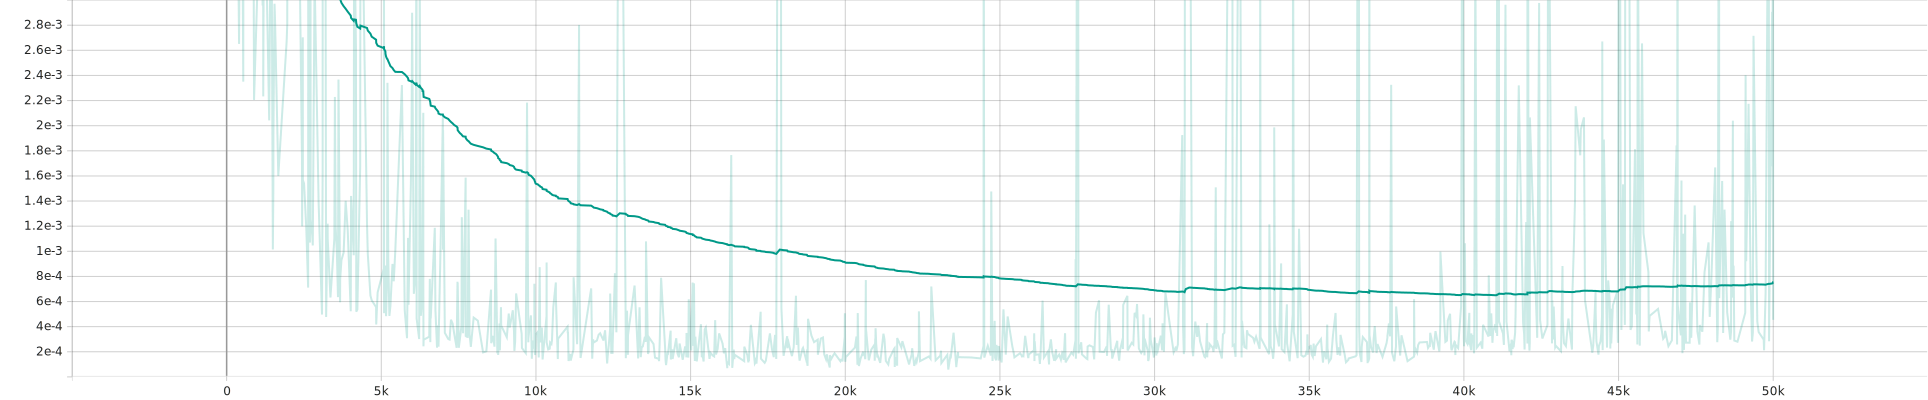

In [26]:
show_svg(loss_train)

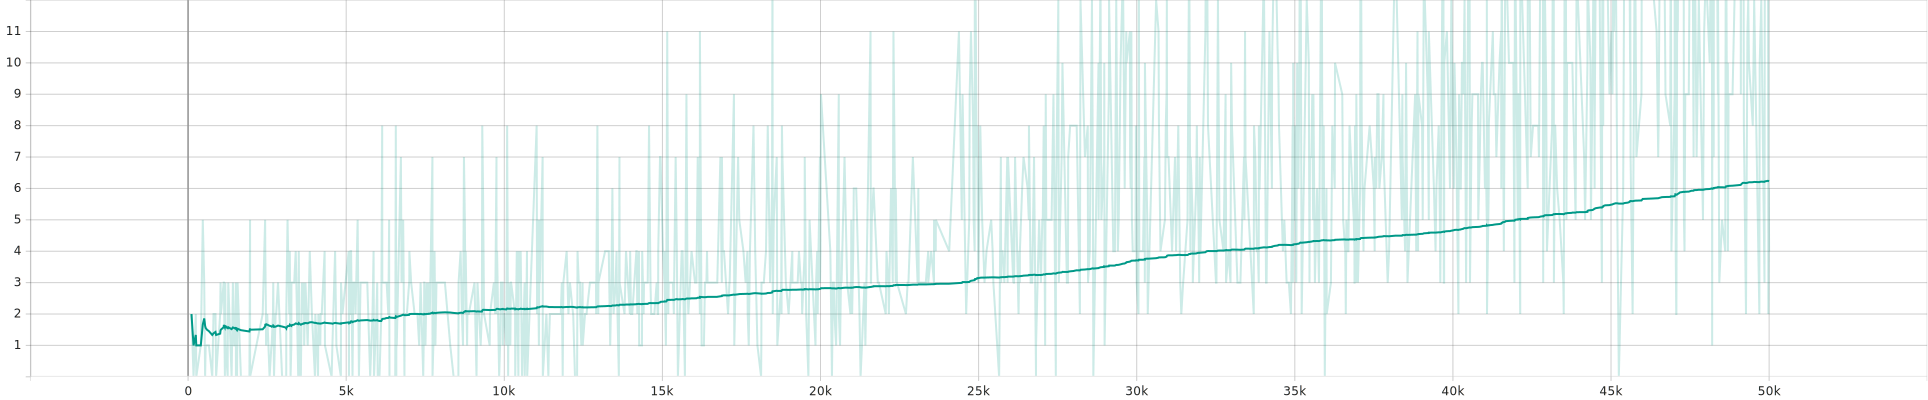

In [27]:
show_svg(score_train)

In [15]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir runs

##### **Evaluation of model**

I will now load the pre-trained model, create a new environment and call the *play_games* function from within the DQN class. The agent will play 10 games and the results will be saved on and visualized with Tensorboard. Kindly note that results may vary from the results saved using this run. 

In [17]:
agent.play_games(10)

/home/kcini75/anaconda3/envs/Atari/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


Episode 1/10: Score: 24.0

Episode 2/10: Score: 28.0

Episode 3/10: Score: 47.0

Episode 4/10: Score: 13.0

Episode 5/10: Score: 19.0

Episode 6/10: Score: 32.0

Episode 7/10: Score: 15.0

Episode 8/10: Score: 9.0

Episode 9/10: Score: 23.0

Episode 10/10: Score: 21.0



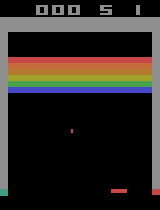

In [18]:
display(Image(data=open('breakout.gif','rb').read(), format='gif'))

In [19]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 107741), started 0:03:09 ago. (Use '!kill 107741' to kill it.)

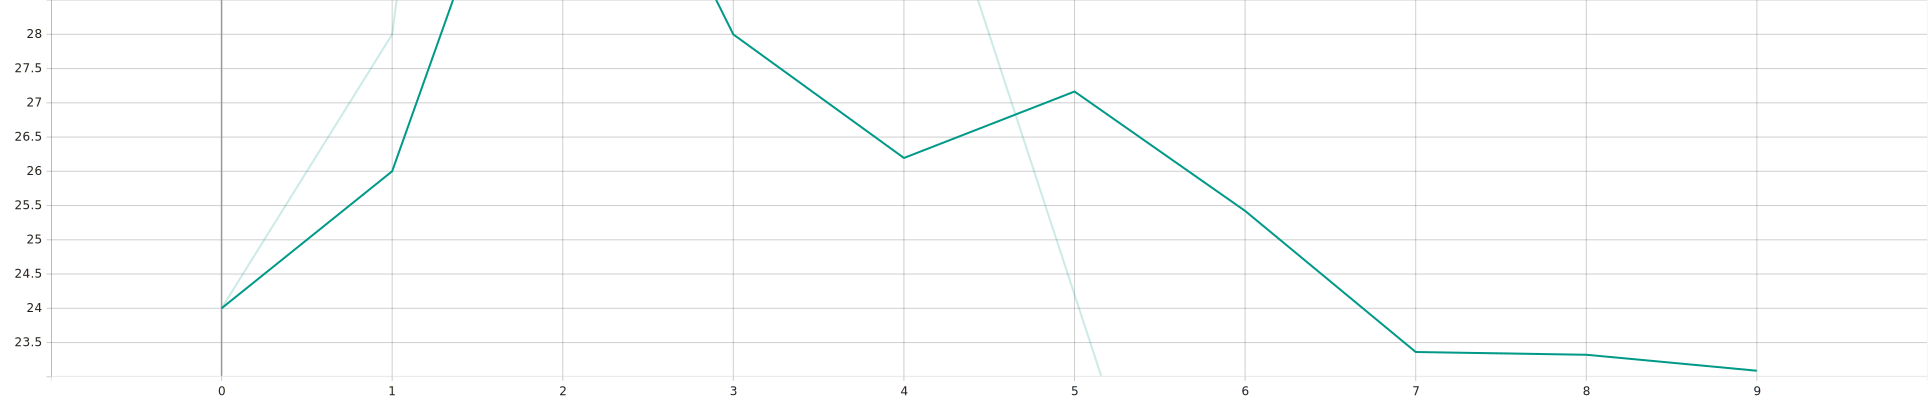

In [28]:
# Loading the evaluation score during this run
evaluation_score = 'evaluation_score.svg'
show_svg(evaluation_score)

#### **Discussion**

The goal of training a DQN agent to play Atari Breakout is to have the agent attain a level of average performance which is higher than that achieved if that agent would be taking random actions. During this experiment it was noted that when the agent chooses actions in a random manner, the average reward for each episode would range between 1.5 and 2 (this can be noted in the intial phase of the training of the agent, where the focus would be on exploration). <br>

The saved metrics, namely the loss and rewards, can be used to evaluate whether the agent has been 'learning' throughout the process. The smoothed decline pattern noticed in the tensorboard output indicates that the agent has indeed been learning to take better decisions given the input (different instances during the game). The actual choice made, as we have noted, is dependent on a number of other factors, mainly controlled by the epsilon-greedy algorithm. I have set an epsilon decay factor of 100,000 which controls the rate at which epsilon is deprecated. With experimentation it has been noted that an average of 10 input steps (transitions seen during training) are seen per episode. <br>

As an example, taking a training run of 30,000 episodes (games), this would translate to circa 300,000 transitions seen during training (i.e. the model would be updated circa 300,000 times). Taking circa 5,000 of initial episodes for warm-up (i.e choosing random actions), if I want to have the exploration rate to decay significantly over the first half of training steps (transitions) then I deduct (5,000*10 transitions = 50,000 transitions) from the expected total transitions of 300,000. This would give 250,000 transitions, which divided by 2 would give 125,000. The epsilon decay factor would be set to 125,000. <br>

Taking this strategy and using the formula of eps_end + (eps_start  - eps_end) * exp(-1 * transitions/epsilon_decay), by setting the epsilon decay at 100,000, the epsilon threshold value decreases the most during the first half of the training. It then continues to decrement towards the eps_end, albeit at a slower pace. As the agent becomes more proficient and the loss decreases, one would expect that with a lower epsilon threshold, the probability of having the agent choose from the policy_network is higher, and hence the average rewards would be expected to rise. <br>

Given the stochastic nature of initilisation of the network weights, I have set a generator to have a consistent initialisation of weights.  <br>

The agent has been trained on 50,000 episodes which translated into 571,420 transitions. As can be noted from the Tensorboard Loss chart, the loss has been steadily decreasing (on average) to a minumum range around the 7e-4 mark. Conversely the smoothed average reward per game slowly increased from the average 1.5/2 (seen during random sampling) to a smoothed average of 6.231 towards the end of the 50k training run. When evaluated over 10 games, the trained model averaged a score of 23, which is a noticeable improvement.  <br>

Overall the selected hyperparameters and network architecture has achieved a satisfactory improvement over the random policy model. 

#### **References**

[1] Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., … Hassabis, D. (2015). Human-level control through deep reinforcement learning. Nature (London), 518(7540), 529–533. <br>
[2] Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2013). Playing Atari with Deep Reinforcement Learning. arXiv.Org, arXiv.org, 2013-12. <br>
[3] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ <br>